In [1]:
# Check GPU type
!nvidia-smi

Thu Aug 29 11:19:49 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0              45W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
# Install ultralytics
!pip -q install  ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 871.6/871.6 kB 46.2 MB/s eta 0:00:00


In [3]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing

In [4]:
# Path to where your data is stored
DATA_DIR = Path('/content/drive/MyDrive/Lacuna')

# Preview data files available
os.listdir(DATA_DIR)

['Train.csv', 'Test.csv', 'SampleSubmission.csv', 'images.zip']

In [5]:
# Set up directoris for training a yolo model

# Images directories
DATASET_DIR = Path('datasets/dataset')
IMAGES_DIR = DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [6]:
# Unzip images to 'images' dir
shutil.unpack_archive(DATA_DIR / 'images.zip', 'images')

In [7]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head()

,Image_ID,class,confidence,ymin,xmin,ymax,xmax,image_path,class_id
0,id_u3q6jdck4j.jpg,Trophozoite,1.0,712,1241,737,1270,images/id_u3q6jdck4j.jpg,0
1,id_a6cl90trri.jpg,Trophozoite,1.0,558,1566,600,1604,images/id_a6cl90trri.jpg,0
2,id_qvc2le9sm8.jpg,Trophozoite,1.0,1317,2788,1448,2914,images/id_qvc2le9sm8.jpg,0
3,id_w8xnbd5rvm.jpg,Trophozoite,1.0,925,1744,1041,1823,images/id_w8xnbd5rvm.jpg,0
4,id_6dop09rk02.jpg,NEG,1.0,0,0,0,0,images/id_6dop09rk02.jpg,2


In [8]:
# Filter out NEG class (Negative images - this images have no Trophozoite nor WBC in them)
# Yolo reccomends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

In [9]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((17354, 9), (5488, 9))

In [10]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.688141
 WBC            0.311859
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.709913
 WBC            0.290087
 Name: proportion, dtype: float64)

In [11]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [12]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [13]:
# Function to convert the bboxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = img.shape

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))

# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

<ipython-input-13-f4a829c8e24a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/17354 [00:00<?, ?it/s]

<ipython-input-13-f4a829c8e24a>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/5488 [00:00<?, ?it/s]

In [14]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('datasets/dataset/images/train')

In [15]:
# Create a data.yaml file required by yolo
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': '/content/' + str(TRAIN_IMAGES_DIR),
    'val': '/content/' + str(VAL_IMAGES_DIR),
    'test': '/content/' + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/content/datasets/dataset/images/train',
 'val': '/content/datasets/dataset/images/val',
 'test': '/content/datasets/dataset/images/test',
 'nc': 2,
 'names': ['Trophozoite', 'WBC']}

Plotting id_od5ejunse8.jpg with 6 bounding boxes.


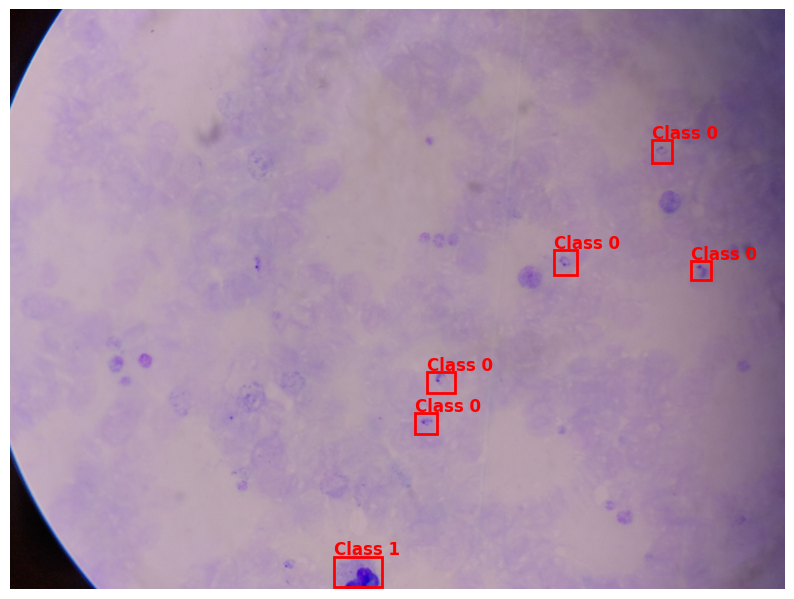

Plotting id_14gsxp9a7x.jpg with 6 bounding boxes.


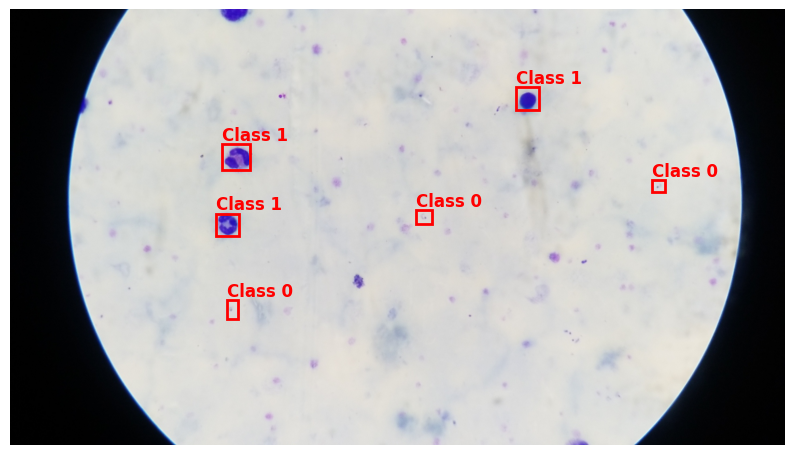

Plotting id_yvg592a7a9.jpg with 3 bounding boxes.


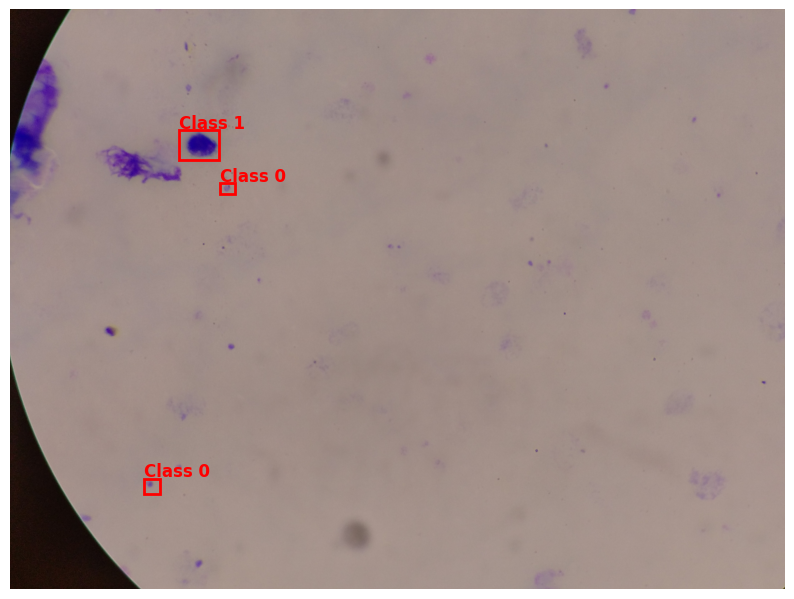

In [16]:
# Plot some images and their bboxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
# Load a yolo pretrained model
model = YOLO('yolov8m.pt')

# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=30,                 # Number of epochs
    imgsz=2048,                # Image size (height, width)
    batch=8,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=5)

100%|██████████| 49.7M/49.7M [00:00<00:00, 548MB/s]


Ultralytics YOLOv8.2.83 🚀 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=30, time=None, patience=5, batch=8, imgsz=2048, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 106MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 366MB/s]


AMP: checks passed ✅


/usr/local/lib/python3.10/dist-packages/ultralytics/engine/trainer.py:268: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /content/datasets/dataset/labels/train... 1544 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1544/1544 [00:01<00:00, 1008.79it/s]


train: New cache created: /content/datasets/dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/dataset/labels/val... 515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:00<00:00, 785.06it/s]

val: New cache created: /content/datasets/dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 2048 train, 2048 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      38.6G      1.938       2.12       1.51        172       2048: 100%|██████████| 193/193 [01:37<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:10<00:00,  3.16it/s]


                   all        515       5488      0.629      0.657      0.627      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      33.4G       1.85      1.526      1.501         92       2048: 100%|██████████| 193/193 [01:33<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.93it/s]

                   all        515       5488      0.683      0.732      0.755      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      36.6G       1.86      1.431      1.498        143       2048: 100%|██████████| 193/193 [01:32<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.86it/s]

                   all        515       5488      0.661       0.76      0.757      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      33.2G      1.837      1.377      1.505         88       2048: 100%|██████████| 193/193 [01:32<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]

                   all        515       5488      0.677      0.722      0.759      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      33.1G      1.832      1.321      1.507        167       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.85it/s]

                   all        515       5488      0.646      0.732      0.727      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      33.8G       1.82      1.281      1.476        104       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.97it/s]

                   all        515       5488      0.738      0.725      0.759      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      34.7G      1.821      1.274      1.489        119       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.91it/s]

                   all        515       5488      0.746      0.751      0.793      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30        36G      1.803      1.253      1.468        112       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.93it/s]

                   all        515       5488      0.765      0.754      0.787      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      33.9G      1.814       1.24      1.482        124       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.89it/s]

                   all        515       5488      0.737       0.79        0.8      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      34.4G      1.781      1.199      1.476         71       2048: 100%|██████████| 193/193 [01:31<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]

                   all        515       5488      0.704      0.795      0.799      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      34.4G      1.781      1.156      1.459        135       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.85it/s]

                   all        515       5488      0.754      0.785      0.809       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      32.7G      1.779      1.151      1.479        204       2048: 100%|██████████| 193/193 [01:32<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.99it/s]

                   all        515       5488      0.779      0.752        0.8       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      33.9G      1.775      1.146      1.461         44       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.89it/s]

                   all        515       5488      0.754      0.794      0.826      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      33.9G      1.773      1.137      1.457         69       2048: 100%|██████████| 193/193 [01:32<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]

                   all        515       5488       0.73      0.784        0.8      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      34.3G      1.773      1.124      1.468        171       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.88it/s]

                   all        515       5488       0.76      0.809      0.823      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      35.3G      1.764      1.108      1.455        100       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]

                   all        515       5488      0.739      0.776      0.797      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      35.6G      1.764      1.094      1.469        180       2048: 100%|██████████| 193/193 [01:32<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]

                   all        515       5488      0.782      0.813      0.835      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      34.5G      1.762      1.091      1.452        159       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.96it/s]

                   all        515       5488       0.76      0.828      0.831      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      33.2G      1.765      1.074      1.463        146       2048: 100%|██████████| 193/193 [01:31<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.94it/s]

                   all        515       5488       0.79      0.809       0.83      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      34.9G      1.757      1.069      1.448        137       2048: 100%|██████████| 193/193 [01:32<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.92it/s]

                   all        515       5488      0.797      0.822      0.846       0.44


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      33.8G       1.76      1.076      1.545         45       2048: 100%|██████████| 193/193 [01:35<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.92it/s]

                   all        515       5488      0.786      0.828      0.842      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      32.2G      1.755      1.075      1.536        203       2048: 100%|██████████| 193/193 [01:31<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.87it/s]

                   all        515       5488      0.776      0.814       0.84      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      32.1G      1.751      1.053       1.54         76       2048: 100%|██████████| 193/193 [01:31<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.95it/s]

                   all        515       5488      0.798      0.828      0.847       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      33.9G      1.736      1.026      1.531         73       2048: 100%|██████████| 193/193 [01:31<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.89it/s]

                   all        515       5488       0.78      0.832      0.844      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      33.8G      1.738      1.019      1.542         59       2048: 100%|██████████| 193/193 [01:31<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.98it/s]

                   all        515       5488      0.774      0.814      0.832      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      33.6G      1.737      1.003      1.524         58       2048: 100%|██████████| 193/193 [01:31<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:08<00:00,  3.91it/s]

                   all        515       5488      0.789      0.827      0.845      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      33.7G      1.704     0.9999      1.503         79       2048:  32%|███▏      | 62/193 [00:29<01:01,  2.12it/s]

In [ ]:
# Validate the model on the validation set
model = YOLO('/content/runs/detect/train/weights/best.pt')
results = model.val()

In [ ]:
# Load the trained YOLO model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Path to the test images directory
test_dir_path = '/content/datasets/dataset/images/test'

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary

    if not boxes:
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,  # You can set this to a default value
            'ymin': 0,  # Default value (no detection)
            'xmin': 0,  # Default value (no detection)
            'ymax': 0,  # Default value (no detection)
            'xmax': 0   # Default value (no detection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

In [ ]:
sub.head()

In [ ]:
sub['class'].value_counts()

In [ ]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_submission.csv', index = False)